# Analysis of Hate Groups and Hate Crimes Data
First, we study the SLP data of Hate groups particularly focusing on **Anti-immigrant groups**. In the last four years, we have seen an increase in the number of hate groups. Particularly, a significant raise in Anti-Immigrant groups is observed, however, it is worth noting that Anti-Immigrant groups are not as predominantly as White Nationalist or Black-separatist groups, in fact, Anti-Immigrant groups in 2019 represented only 2% of the total hate groups in the US. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [10]:
hg = pd.read_csv('data/splc-hate-groups.csv')
hg.head(10)

,Title,City,State,Group,Ideology,Headquarters,Statewide,Year
0,American Border Patrol,Sierra Vista,Arizona,American Border Patrol/American Patrol,Anti-Immigrant,Yes,NaN,2019
1,American Immigration Control Foundation/Americ...,Monterey,Virginia,NaN,Anti-Immigrant,Yes,NaN,2019
2,Americans for Legal Immigration (ALIPAC),Raleigh,North Carolina,NaN,Anti-Immigrant,Yes,NaN,2019
3,AZ Patriots,NaN,Arizona,NaN,Anti-Immigrant,Yes,Yes,2019
4,Californians for Population Stabilization,Ventura,California,NaN,Anti-Immigrant,NaN,NaN,2019
5,Center for Immigration Studies,Washington,District of Columbia,Center for Immigration Studies,Anti-Immigrant,Yes,NaN,2019
6,Colorado Alliance for Immigration Reform,Lakewood,Colorado,NaN,Anti-Immigrant,Yes,NaN,2019
7,Federation for American Immigration Reform,Washington,District of Columbia,Federation for American Immigration Reform,Anti-Immigrant,Yes,NaN,2019
8,Floridians for Immigration Enforcement,Pompano Beach,Florida,NaN,Anti-Immigrant,NaN,NaN,2019
9,Help Save Maryland,Monkton,Maryland,NaN,Anti-Immigrant,Yes,NaN,2019


In [11]:
pp = hg[(hg.Ideology == 'Anti-Immigrant') & (hg.Year == 2019)].shape[0]/hg[hg.Year == 2019].shape[0] *100
print('In 2019, Anti-Immigrant groups represented {}% of the total number of hate groups'.format(round(pp,2)))

In 2019, Anti-Immigrant groups represented 2.13% of the total number of hate groups


## 1. Looking at Hate Groups Over Time

In [12]:
counts = hg.groupby(['Year', 'Ideology']).size().reset_index(name='count')
top3 = counts.sort_values(by=['Year','count'], ascending=[True, False]).groupby('Year').head(3)

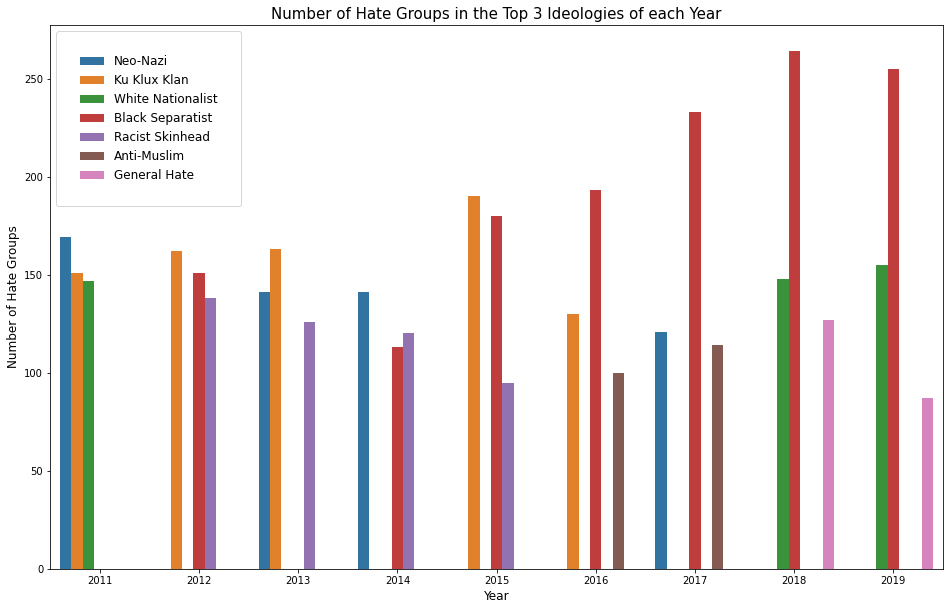

In [19]:
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x="Year", y="count", hue='Ideology', data=top3[top3.Year > 2010])
ax.legend(loc='upper left', borderpad=2, prop={'size':12})
plt.title('Number of Hate Groups in the Top 3 Ideologies of each Year', size=15)
plt.ylabel('Number of Hate Groups', size=12)
plt.xlabel('Year', size=12)
plt.show()

### 1.1 Hate Groups in State level

In [20]:
#Obtain geometries of US States
us = gpd.read_file('data/shapes/tl_2017_us_state.shp')
us = us[['STUSPS', 'GEOID', 'NAME', 'REGION', 'geometry']]
non_states = ['Commonwealth of the Northern Mariana Islands', 'Guam','Puerto Rico', 
              'American Samoa', 'United States Virgin Islands']
us = us.drop(us[us.apply(lambda x: True if x['NAME'] in non_states else False, axis=1)].index)
us.set_index('GEOID', inplace=True)
#Obtain population estimates
pop = pd.read_csv('data/population.csv')

In [21]:
#Merge with the counts of 2019, US Shapes and population
counts= hg.groupby(['State', 'Year']).size().reset_index(name='count')
counts_g = us[['NAME', 'geometry']].merge(counts[counts.Year == 2019], 
                                              right_on='State', left_on='NAME', 
                                              how='left').fillna({'count':0, 'Year':2019,
                                                                  'Ideology':'Anti-Immigrant'})
counts_g['State'] = counts_g['NAME']
counts_g.drop(columns=['NAME'], inplace=True)
counts_g = counts_g.merge(pop[pop.Year==2019][['State', 'population']], on=['State'])
counts_g['count_norm']= counts_g['count']*1000000/counts_g['population']

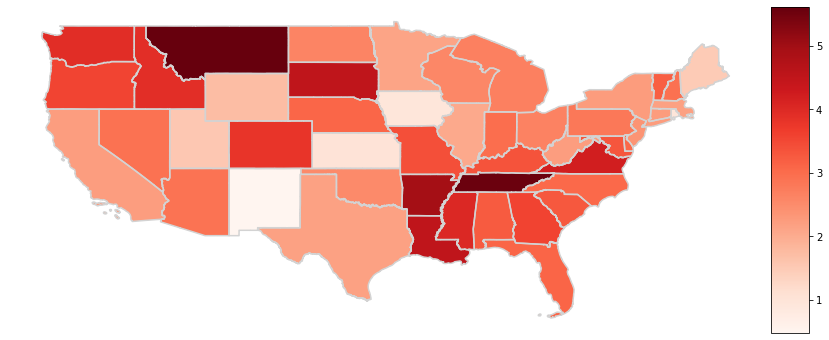

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
c_lim = counts_g[counts_g.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Hate Groups Per Million People in 2019', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c_lim.plot(column='count_norm',cmap='Reds',legend=True,ax=ax, cax=cax)
c_lim.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

### 1.2 Anti-Immigrant Groups

In [33]:
counts=hg.groupby(['Year', 'Ideology']).size().reset_index(name='count')
counts_im = counts[counts.Ideology == 'Anti-Immigrant']

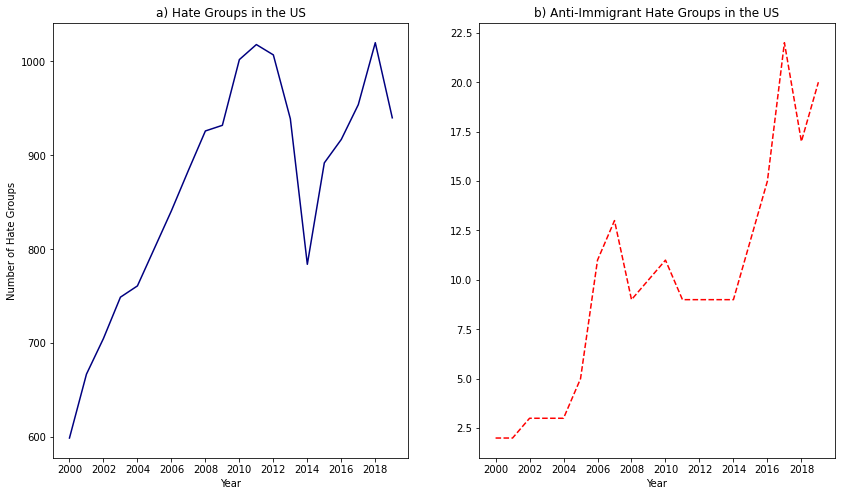

In [34]:
fig, ax = plt.subplots(figsize=(14,8), ncols=2, nrows=1)
ax1 = sns.lineplot(x="Year", y="count", 
                   data=counts.groupby('Year').agg({'count':'sum'}).reset_index(), 
                  color='navy', ax=ax[0])
freq = int(2)
ax1.set_xticks(counts.groupby('Year').agg({'count':'sum'}).reset_index().Year[::freq])
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Hate Groups')
ax1.title.set_text('a) Hate Groups in the US')


ax2 = sns.lineplot(x="Year", y="count", data=counts_im, color='red', ax=ax[1])
ax2.set_xticks(counts_im.Year[::freq])
ax2.lines[0].set_linestyle("--")
ax2.set_xlabel('Year')
ax2.set_ylabel('')
ax2.title.set_text('b) Anti-Immigrant Hate Groups in the US')

plt.show()

In [35]:
#Create a df at state, year and ideology levels. 
counts = hg.groupby(['State', 'Year', 'Ideology']).size().reset_index(name='count')

In [28]:
#Merge with the counts of 2019 and Anti-Immigrant groups
counts_g = us[['NAME', 'geometry']].merge(counts[(counts.Year == 2019) & 
                                                     (counts.Ideology == 'Anti-Immigrant')], 
                                              right_on='State', left_on='NAME', 
                                              how='left').fillna({'count':0, 'Year':2019,
                                                                  'Ideology':'Anti-Immigrant'})
counts_g['State'] = counts_g['NAME']
counts_g.drop(columns=['NAME'], inplace=True)

In [29]:
#Normalize the size of anti-immigrant groups per population
counts_g = counts_g.merge(pop[pop.Year==2019][['State', 'population']], on=['State'])
counts_g['count_norm']= counts_g['count']*1000000/counts_g['population']

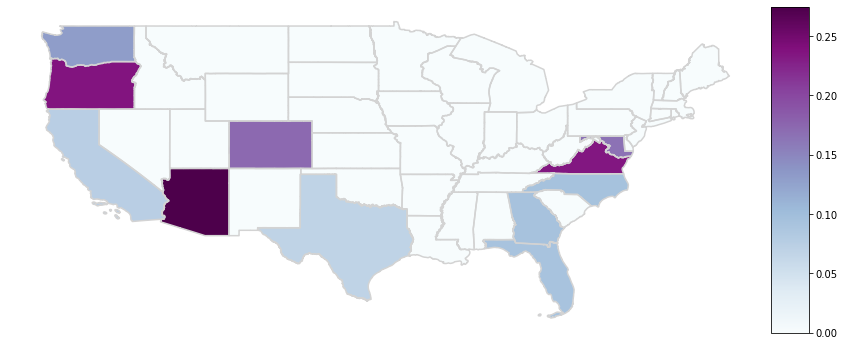

In [31]:
c_lim = counts_g[counts_g.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
fig, ax = plt.subplots(figsize=(15,6))
#plt.title('Number of Anti-Immigrant Hate Groups Per Million People in 2019', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c_lim.plot(column='count_norm',cmap='BuPu',legend=True,ax=ax, cax=cax)
c_lim.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

## 2. Hate crimes in the US 
To analyze hate crimes in the US, we rely on the Uniform Crime Report (UCR) data, although it is worth noting that these reports may be highly underestimating the real number of hate crimes (See: [Pezzella et al. (2019)](https://doi.org/10.1177%2F0002764218823844)).

In [2]:
#Get FBI data on hate crimes, limit to Single bias crimes only
hc = pd.read_csv('data/ucr_hatecrimes.csv', sep=',', dtype='unicode')
hc = hc[hc.MULTIPLE_BIAS == 'S']
hc['DATA_YEAR'] = hc['DATA_YEAR'].astype(int)

In [3]:
import re
import numpy as np
def reduce_category(word):
    '''
    Find just one category of the incident
    '''
    w = word.lower()
    w = re.sub('[^A-Za-z0-9]+', ' ', w)
    race = ['black', 'white', 'race', 'native', 'asian', 'latino', 'hispanic', 'arab']
    lgbt = ['gay', 'lesbian', 'bisexual', 'transgender', 'gender']
    gender = ['female', 'male']
    religious = ['jewish', 'protestant', 'religion','muslim', 'islam','catholic',
                'atheism', 'jenovah', 'mormon', 'buddhist', 'sikh', 'christian', 'hindu', 'orthodox']
    for i in race:
        if i in w:
            return 'race_{}'.format(i)
    for i in lgbt:
        if i in w:
            return 'lgbt'
    for i in gender:
        if i in w:
            return 'gender'
    for i in religious:
        if i in w:
            return 'r_{}'.format(i)
    
    return 'other'

In [4]:
hc['cat'] = hc.apply(lambda row: reduce_category(row['BIAS_DESC']), axis=1)
hc['race'] = np.where(hc.cat.str.startswith('race_'),hc.cat.str.replace('race_',''), np.nan)
hc['cat'] = np.where(hc.cat.str.startswith('race_'),'race',hc.cat)
hc['religious'] = np.where(hc.cat.str.startswith('r_'),hc.cat.str.replace('r_',''), np.nan)
hc['cat'] = np.where(hc.cat.str.startswith('r_'),'religious',hc.cat)

In [5]:
counts = hc.groupby(['DATA_YEAR', 'cat']).size().reset_index(name='count')

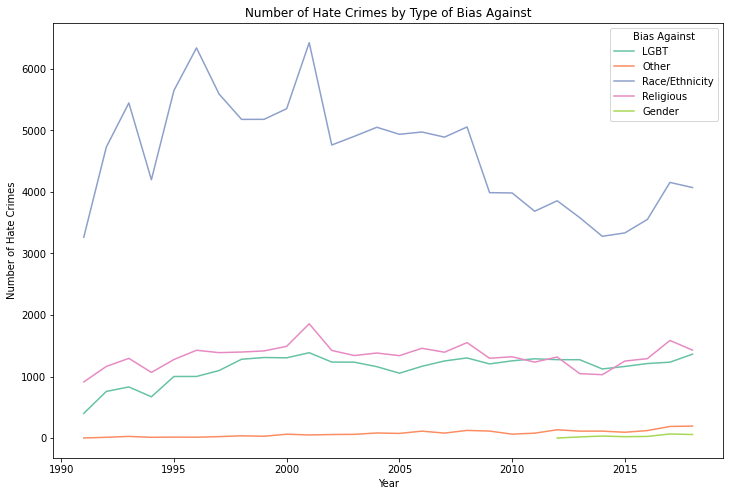

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='cat', data=counts, ax=ax, palette='Set2')
ax.legend(labels=['LGBT', 'Other', 'Race/Ethnicity', 'Religious', 'Gender'], title='Bias Against')
plt.xlabel('Year')
plt.ylabel('Number of Hate Crimes')
plt.title('Number of Hate Crimes by Type of Bias Against')
plt.show()

As shown in the graph, since 1990, anti-race bias has been the leading motivation for hate crimes. 

### 2.1 Hate Crimes Against Latinos, Asians, and Arabs.

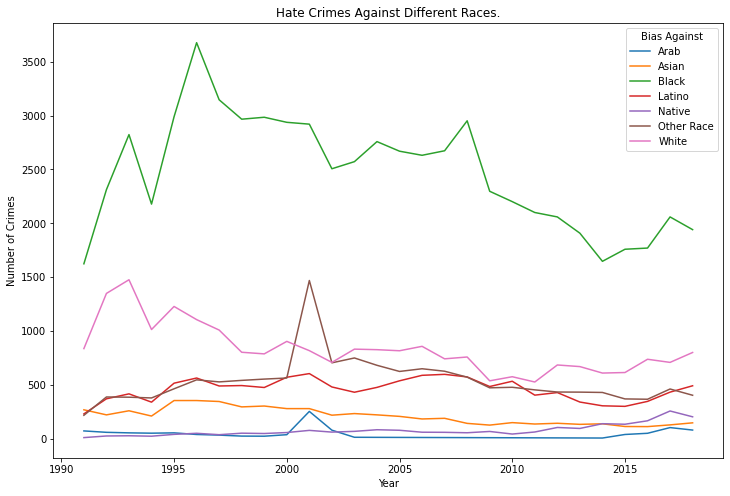

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='race', 
             data=hc.groupby(['DATA_YEAR', 'race']).size().reset_index(name='count'), 
             ax=ax)
ax.legend(labels=['Arab', 'Asian', 'Black','Latino', 'Native', 'Other Race', 'White'], title='Bias Against')
plt.title('Hate Crimes Against Different Races.')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

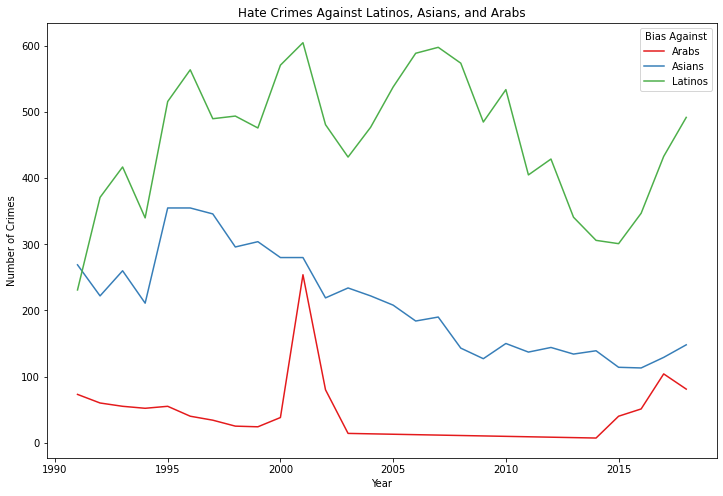

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='race', 
             data=hc[(hc.race == 'latino' )| (hc.race == 'asian') |
                    (hc.race == 'arab')].groupby(['DATA_YEAR', 'race']).size().reset_index(name='count'), 
             ax=ax, palette='Set1')
ax.legend(labels=['Arabs', 'Asians', 'Latinos'], title='Bias Against')
plt.title('Hate Crimes Against Latinos, Asians, and Arabs')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

#### State level perspective

In [66]:
#Merge population with State polygons
us_p = us.merge(pop, right_on='State', left_on='NAME')
us_p.drop(columns=['NAME', 'REGION'], inplace=True)
us_p.head(10)

,STUSPS,geometry,State,Year,population
0,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2010,1854239
1,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2011,1856301
2,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2012,1856872
3,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2013,1853914
4,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2014,1849489
5,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2015,1842050
6,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2016,1831023
7,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2017,1817004
8,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2018,1804291
9,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2019,1792147


In [67]:
#Get number of hate crimes to hispanic/latino
hc_latino = hc[(hc.DATA_YEAR > 2009) & 
               (hc.race == 'latino')].groupby(['STATE_NAME', 
                                                    'DATA_YEAR', 
                                                    'race']).size().reset_index(name='count')
hc_latino.drop(columns=['race'], inplace=True)
hc_latino = us_p.merge(hc_latino, left_on=['State', 'Year'], right_on=['STATE_NAME','DATA_YEAR'], how='left')
hc_latino.drop(columns=['STATE_NAME', 'DATA_YEAR'], inplace=True)
hc_latino['count_n'] = hc_latino['count']*1000000/hc_latino['population']

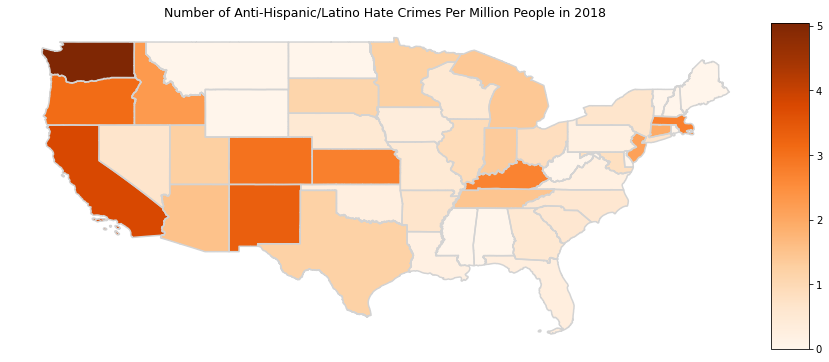

In [68]:
lat_map = hc_latino[hc_latino.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
lat_map = lat_map[lat_map.Year == 2018]
lat_map.fillna({'count_n':0}, inplace=True)
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Anti-Hispanic/Latino Hate Crimes Per Million People in 2018', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
lat_map.plot(column='count_n',cmap='Oranges',legend=True,ax=ax, cax=cax)
lat_map.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

### 2.2 Hate Crimes against Jews and Muslims

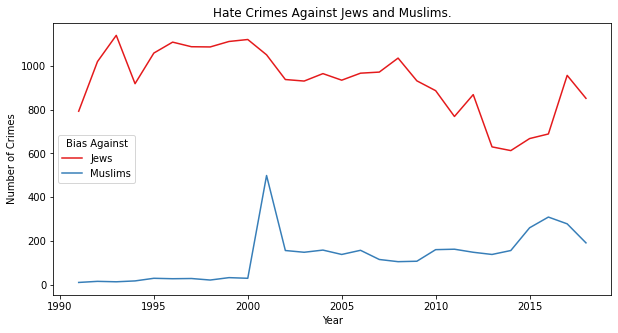

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="DATA_YEAR", y="count", hue='religious', 
             data=hc[(hc.religious == 'jewish') | 
                     (hc.religious == 'muslim')].groupby(['DATA_YEAR', 
                                                          'religious']).size().reset_index(name='count'), 
             ax=ax, palette='Set1')
ax.legend(labels=['Jews', 'Muslims'], title='Bias Against')
plt.title('Hate Crimes Against Jews and Muslims.')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

## 3. Census data: Median Income and Immigrants Population
All information of census data is downloaded from Census Data API
We used [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs/technical-documentation/summary-file-documentation.html) data of ACS 5-year estimates.
For more documentation see: 
* [Census Data python module](https://jtleider.github.io/censusdata/)
* [Example dowloading State data](https://jtleider.github.io/censusdata/example3.html)
* [Accessing Census Data with Python](https://towardsdatascience.com/accessing-census-data-with-python-3e2f2b56e20d)

In [37]:
import censusdata
#censusdata.search('acs5', 2015,'concept', 'Foreign-Born')
#censusdata.printtable(censusdata.censustable('acs5', 2015, 'B05006'))

In [95]:
d = {'B03002_012E': 'hispanic_pop', 'B19013_001E':'median_income', 
     'B01001_001E':'population', 'B05006_124E': 'latin_born', 
     'B05006_139E': 'mexican_born'}
statedata = censusdata.download('acs5', 2018, censusdata.censusgeo([('state', '*')]),
                                ['B01001_001E', 'B19013_001E', 'B03002_012E',
                                'B05006_124E', 'B05006_139E'])
statedata = statedata.drop([censusdata.censusgeo([('state', '72')])])
statedata.rename(columns=d, inplace=True)
statedata = statedata.reset_index().rename(columns={'index':'State'})

In [119]:
statedata['State']=statedata.State.apply(lambda x: x.name)

In [120]:
statedata['hispanic']

,State,population,median_income,hispanic_population,latin_born,mexican_born
0,Minnesota,5527358,68411,292764,113472.0,64492.0
1,Mississippi,2988762,43567,90493,35707.0,23319.0
2,Missouri,6090062,53560,249105,73876.0,43580.0
3,Montana,1041732,52559,39019,4688.0,2564.0
4,Nebraska,1904760,59116,203281,71636.0,47642.0
5,Nevada,2922849,57598,831597,318548.0,226047.0
6,New Hampshire,1343622,74057,48356,16001.0,2187.0
7,New Jersey,8881845,79363,1768020,903388.0,114932.0
8,New Mexico,2092434,48059,1015751,153126.0,139747.0
9,New York,19618453,65323,3705588,2169867.0,225373.0
